#### importing the needed libraries

In [1]:
import sqlite3
import pandas as pd
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings

warnings.filterwarnings("ignore")

### showing the whole column
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

#### connecting to the accident database

In [2]:

con = sqlite3.connect("accident_data_v1.0.0_2023.db")

cur =  con.cursor()

acc_col_info = cur.execute(f"PRAGMA table_info(accident)").fetchall()
veh_col_info = cur.execute(f"PRAGMA table_info(vehicle)").fetchall()
cas_col_info = cur.execute(f"PRAGMA table_info(casualty)").fetchall()
lsoa_col_info = cur.execute(f"PRAGMA table_info(lsoa)").fetchall()

#### creating a list for column names for each table

In [3]:
acc_col_names=[]
for i in acc_col_info:
    acc_col_names.append(i[1])
    
veh_col_names=[]
for i in veh_col_info:
    veh_col_names.append(i[1])
    
cas_col_names=[]
for i in cas_col_info:
    cas_col_names.append(i[1])
    
lsoa_col_names=[]
for i in lsoa_col_info:
    lsoa_col_names.append(i[1])

#### creating a DataFrame format from each table in the database 

In [4]:
accident = cur.execute("SELECT * FROM accident WHERE accident_year = 2020").fetchall()
vehicle = cur.execute("SELECT * FROM vehicle WHERE accident_year = 2020").fetchall()
casualty = cur.execute("SELECT * FROM casualty WHERE accident_year = 2020"). fetchall()
lsoa = cur.execute("SELECT * FROM lsoa")

df_acc = pd.DataFrame(accident, columns= acc_col_names)
df_veh = pd.DataFrame(vehicle, columns= veh_col_names)
df_cas = pd.DataFrame(casualty, columns= cas_col_names)
df_lsoa = pd.DataFrame(lsoa, columns = lsoa_col_names)

#### cleaning the datasets

In [5]:
#### replacing the wrongly imputed datas in their corresponding columns, with the most logical replacements.

df_acc['light_conditions']=df_acc['light_conditions'].replace(-1, 1)
df_acc['speed_limit']=df_acc['speed_limit'].replace(-1, 10)
df_acc['weather_conditions']=df_acc['weather_conditions'].replace(-1, 1)
df_acc['road_surface_conditions']=df_acc['road_surface_conditions'].replace(-1, 1)

In [ ]:
local_authority_ons_district_list = ['E08000013', 'E06000050', 'E07000164', 'E08000036', 'E06000024', 'W06000015', 'W06000010', 'W06000010', 'W06000010', 'W06000010', 'W06000010', 'W06000009', 'W06000009', 'W06000023']

# Iterate through each local authority district and fill NaN values with the median longitude
for district in local_authority_ons_district_list:
    # Filter the DataFrame to get rows where 'local_authority_ons_district' is the current district
    filtered_df = df_acc[df_acc['local_authority_ons_district'] == district]

    # Calculate the median of the 'longitude' column in the filtered DataFrame
    median_longitude = filtered_df['longitude'].median()

In [134]:
local_authority_ons_district_list = ['E08000013', 'E06000050', 'E07000164', 'E08000036', 'E06000024', 'W06000015', 'W06000010', 'W06000010', 'W06000010', 'W06000010', 'W06000010', 'W06000009', 'W06000009', 'W06000023']

# Iterate through each local authority district and fill NaN values with the median longitude
for district in local_authority_ons_district_list:
    # Filter the DataFrame to get rows where 'local_authority_ons_district' is the current district
    filtered_df = df_acc[df_acc['local_authority_ons_district'] == district]

    # Calculate the median of the 'longitude' column in the filtered DataFrame
    median_longitude = filtered_df['longitude'].median()

    # Fill the NaN values in the 'longitude' column with the mean value
    df_acc.loc[df_acc['local_authority_ons_district'] == district, 'longitude'] = df_acc.loc[df_acc['local_authority_ons_district'] == district, 'longitude'].fillna(median_longitude)

In [137]:
filtered_df = df_acc[df_acc['latitude'].isnull()]

# Access the values of 'local_authority_ons_district' column from the filtered DataFrame
district_values_with_nan_latitude= filtered_df['local_authority_ons_district'].tolist()


local_authority_ons_district_list = ['E08000013', 'E06000050', 'E07000164', 'E08000036', 'E06000024', 'W06000015', 'W06000010', 'W06000010', 'W06000010', 'W06000010', 'W06000010', 'W06000009', 'W06000009', 'W06000023']

# Iterate through each local authority district and fill NaN values with the median longitude
for district in local_authority_ons_district_list:
    # Filter the DataFrame to get rows where 'local_authority_ons_district' is the current district
    filtered_df = df_acc[df_acc['local_authority_ons_district'] == district]

    # Calculate the mean of the 'longitude' column in the filtered DataFrame
    median_latitude = filtered_df['latitude'].median()

    # Fill the NaN values in the 'longitude' column with the mean value
    df_acc.loc[df_acc['local_authority_ons_district'] == district, 'latitude'] = df_acc.loc[df_acc['local_authority_ons_district'] == district, 'latitude'].fillna(median_latitude)

In [138]:
### checking the null values
df_acc.isnull().sum().head(8)

accident_index             0
accident_year              0
accident_reference         0
location_easting_osgr     14
location_northing_osgr    14
longitude                  0
latitude                   0
police_force               0
dtype: int64

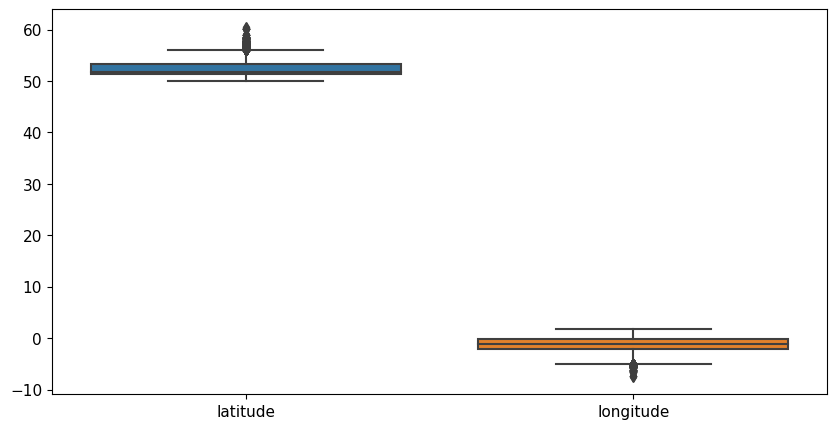

In [7]:
#checking for outliers in specified column

df_check = df_acc[['latitude','longitude']]

fig, ax = plt.subplots(figsize=(10, 5))
sns.boxplot(df_check)

#displaying the plot
ax.tick_params(axis='y', labelsize=11)
ax.tick_params(axis='x', labelsize=11)

plt.show()

In [8]:
# ### grouping local_authority_ons_district by their latitudes

# df_ons1 = df_acc.groupby('local_authority_ons_district')['latitude'].apply(list).reset_index()

# #getting the mean of the latitudes
# df_ons['latitude']= df_ons1['latitude'].apply(lambda x: sum(x)/len(x))

# df_ons

#### Extracting the needed columns for the first three analysis from the database

In [9]:
#joining the accident, vehicle and casualty table
data = cur.execute('''SELECT vehicle.vehicle_type,casualty.casualty_class, accident.time, accident.day_of_week
                FROM accident JOIN vehicle ON accident.accident_index=vehicle.accident_index 
                JOIN casualty on accident.accident_index = casualty.accident_index 
                WHERE accident.accident_year = 2020
                ''').fetchall()

df = pd.DataFrame(data, columns = ['vehicle_type','casualty_class','time','day_of_week'])

## replacing casualty_class with actual meaning
df = df.replace({'casualty_class' : {1 : 'Driver', 2 : 'Passenger', 3 : 'Pedestrian'}})

# replacing the day of the week with actual meaning
df= df.replace({'day_of_week' : {2 : 'Monday',
                                 3 : 'Tuesday',
                                 4 : 'wednesday',
                                 5 : 'Thursday',
                                 6: 'Friday',
                                 7: 'Saturday',
                                 1: 'Sunday'}})

## converting TIME  from string to float
def time_string_to_decimals(time_string):
    fields = time_string.split(":")
    hours = fields[0] if len(fields) > 0 else 0.0
    minutes = fields[1] if len(fields) > 1 else 0.0
    seconds = fields[2] if len(fields) > 2 else 0.0
#     return float(hours) + (float(minutes) / 60.0) + (float(seconds) / pow(60.0, 2))
    return float(hours)

df['time'] = df['time'].map(time_string_to_decimals)

####  1.0 Are there significant hours of the day, and days of the week, on which accidents occur?

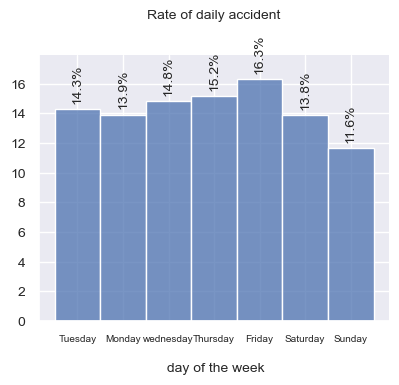

In [10]:
# plot of days of the week of accident occurrences

sns.set_theme(style="darkgrid")


fg = sns.displot(data=df, x='day_of_week', stat='percent', height=3.5, aspect=1.25)
fg.fig.set_dpi(100)

for ax in fg.axes.ravel():
    
    # add annotations
    for q in ax.containers:

        # custom label calculates percent and add an empty string so 0 value bars don't have a number
        labels = [f'{w:0.1f}%' if (w := v.get_height()) > 0 else '' for v in q]

        ax.bar_label(q, labels=labels, label_type='edge', fontsize=10, rotation=90, padding= 4)
    
    ax.margins(y=0.1)
ax.tick_params(axis='y', labelsize=10)
ax.tick_params(axis='x', labelsize=7.2)
plt.title('Rate of daily accident\n\n', fontsize= 10)
plt.ylabel('', fontsize=10)
plt.xlabel("\n day of the week", fontsize = 10)
plt.show()

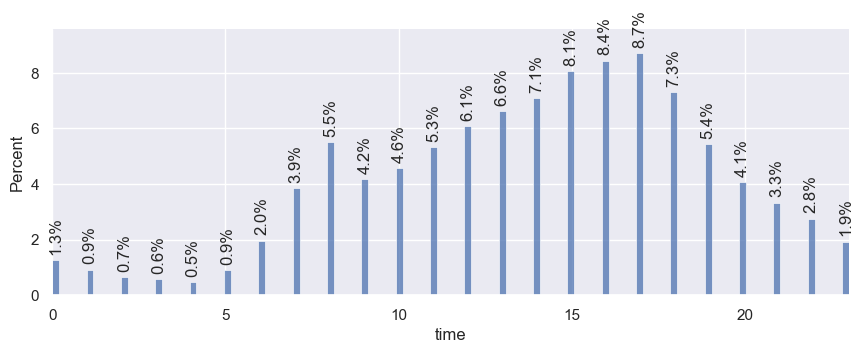

In [11]:
#plot of hourly rate of accidents

fg = sns.displot(data=df, x='time', stat='percent', height=3.5, aspect=2.5)

for ax in fg.axes.ravel():
    
    # add annotations
    for c in ax.containers:

        # custom label calculates percent and add an empty string so 0 value bars don't have a number
        labels = [f'{w:0.1f}%' if (w := v.get_height()) > 0 else '' for v in c]

        ax.bar_label(c, labels=labels, label_type='edge', fontsize=12, rotation=90, padding=4)
    
    ax.margins(y=0.1,x=0)

plt.show() 

#### 2.0 For motorbikes, are there significant hours of the day, and days of the week, on which accidents occur?¶
#### with focus Motorcycle 125cc and under, Motorcycle over 125cc and up to 500cc, and Motorcycle over 500cc

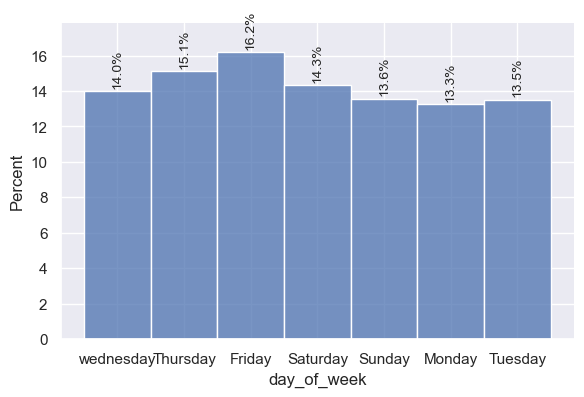

In [12]:
# daily rate of accident occurrences

df_Mcycle = df.loc[(df['vehicle_type']==2)|(df['vehicle_type']==3)|(df['vehicle_type']==4)|(df['vehicle_type']==5)]

fg = sns.displot(data=df_Mcycle, x='day_of_week', stat='percent', height=4.0, aspect=1.5)
fg.fig.set_dpi(100)

for ax in fg.axes.ravel():
    
    # add annotations
    for c in ax.containers:

        # custom label calculates percent and add an empty string so 0 value bars don't have a number
        labels = [f'{w:0.1f}%' if (w := v.get_height()) > 0 else '' for v in c]

        ax.bar_label(c, labels=labels, label_type='edge', fontsize=10, rotation=90, padding=2)
    
    ax.margins(y=0.1)

plt.show()

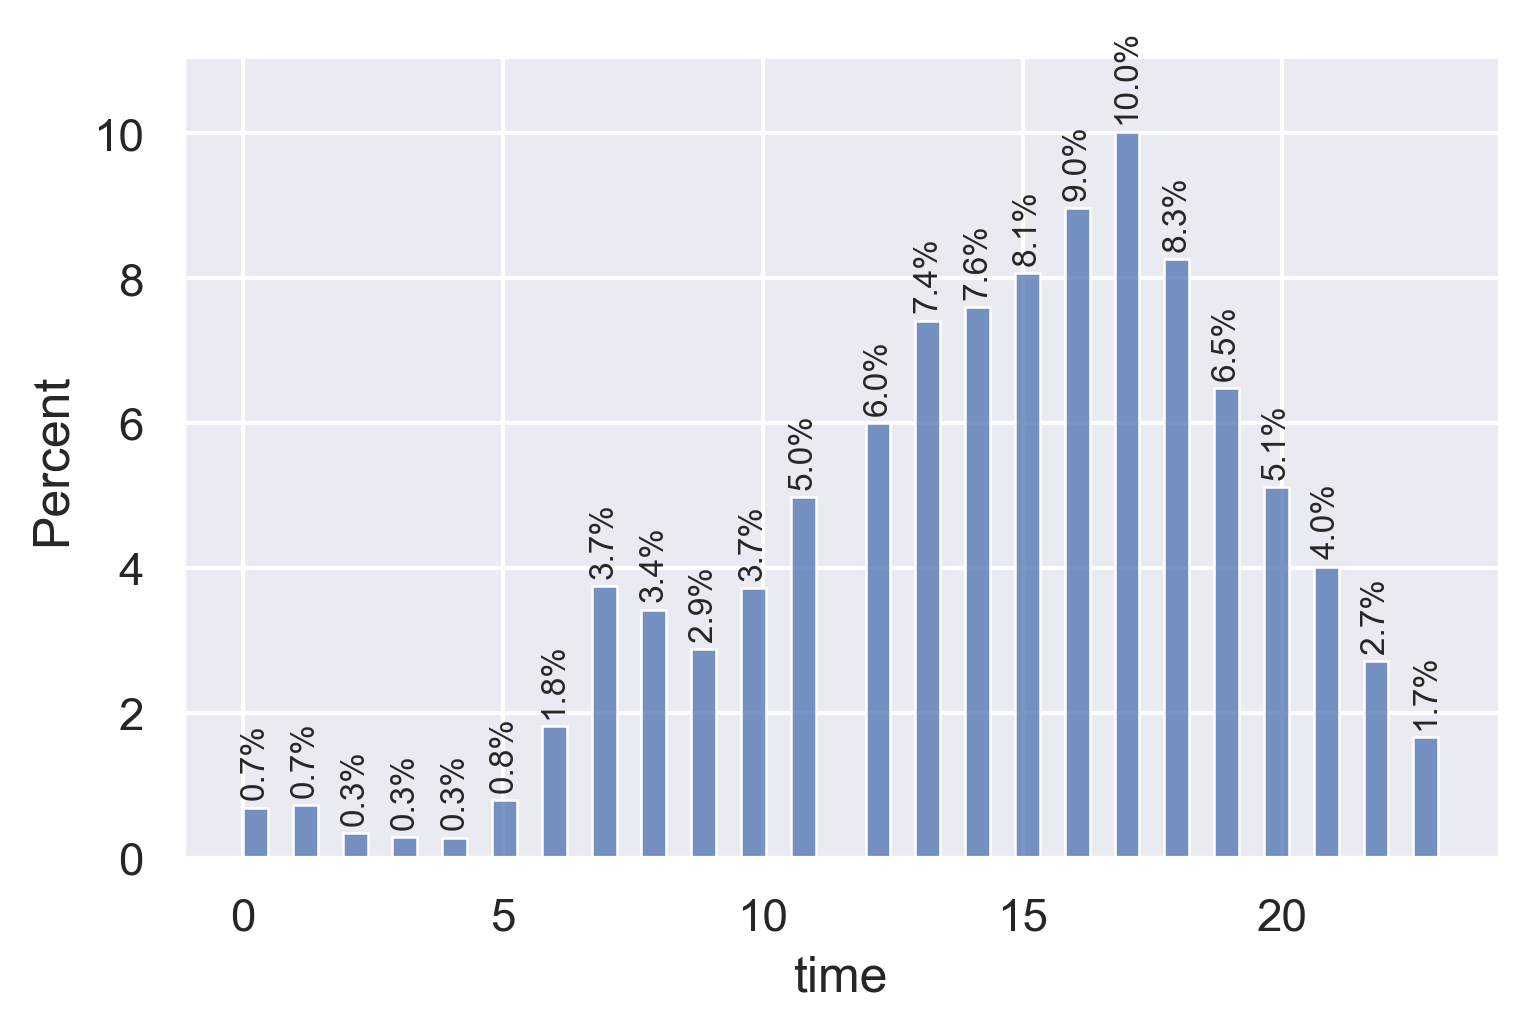

In [13]:
## hourly rate of motorcycle accident accident occurrences

fg = sns.displot(data=df_Mcycle, x='time', stat='percent', height=3.5, aspect=1.5)
fg.fig.set_dpi(300)

for ax in fg.axes.ravel():
    
    # add annotations
    for c in ax.containers:

        # custom label calculates percent and add an empty string so 0 value bars don't have a number
        labels = [f'{w:0.1f}%' if (w := v.get_height()) > 0 else '' for v in c]

        ax.bar_label(c, labels=labels, label_type='edge', fontsize=8, rotation=90, padding=2)
    
    ax.margins(y=0.1)

plt.show()

#### 2.0 For motorbikes, are there significant hours of the day, and days of the week, on which accidents occur?

####  with focus Motorcycle 125cc and under, Motorcycle over 125cc and up to 500cc, and Motorcycle over 500cc.

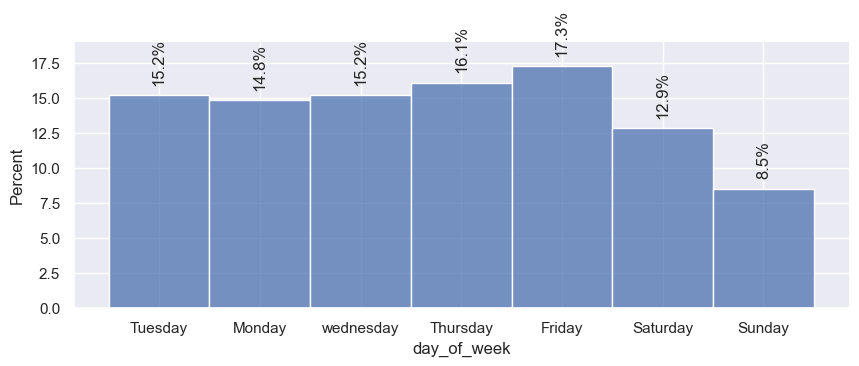

In [14]:
## Motorcycle 125cc and under, Motorcycle over 125cc and up to 500cc, and Motorcycle over 500cc

df_Ped = df[(df['casualty_class']=='Pedestrian')]

### Plot Daily rate of motorcycle accidents

fg = sns.displot(data=df_Ped, x='day_of_week', stat='percent', height=3.5, aspect=2.5)

for ax in fg.axes.ravel():
    
    # add annotations
    for c in ax.containers:

        # custom label calculates percent and add an empty string so 0 value bars don't have a number
        labels = [f'{w:0.1f}%' if (w := v.get_height()) > 0 else '' for v in c]

        ax.bar_label(c, labels=labels, label_type='edge', fontsize=12, rotation=90, padding=7)
    
    ax.margins(y=0.1)

plt.show() 

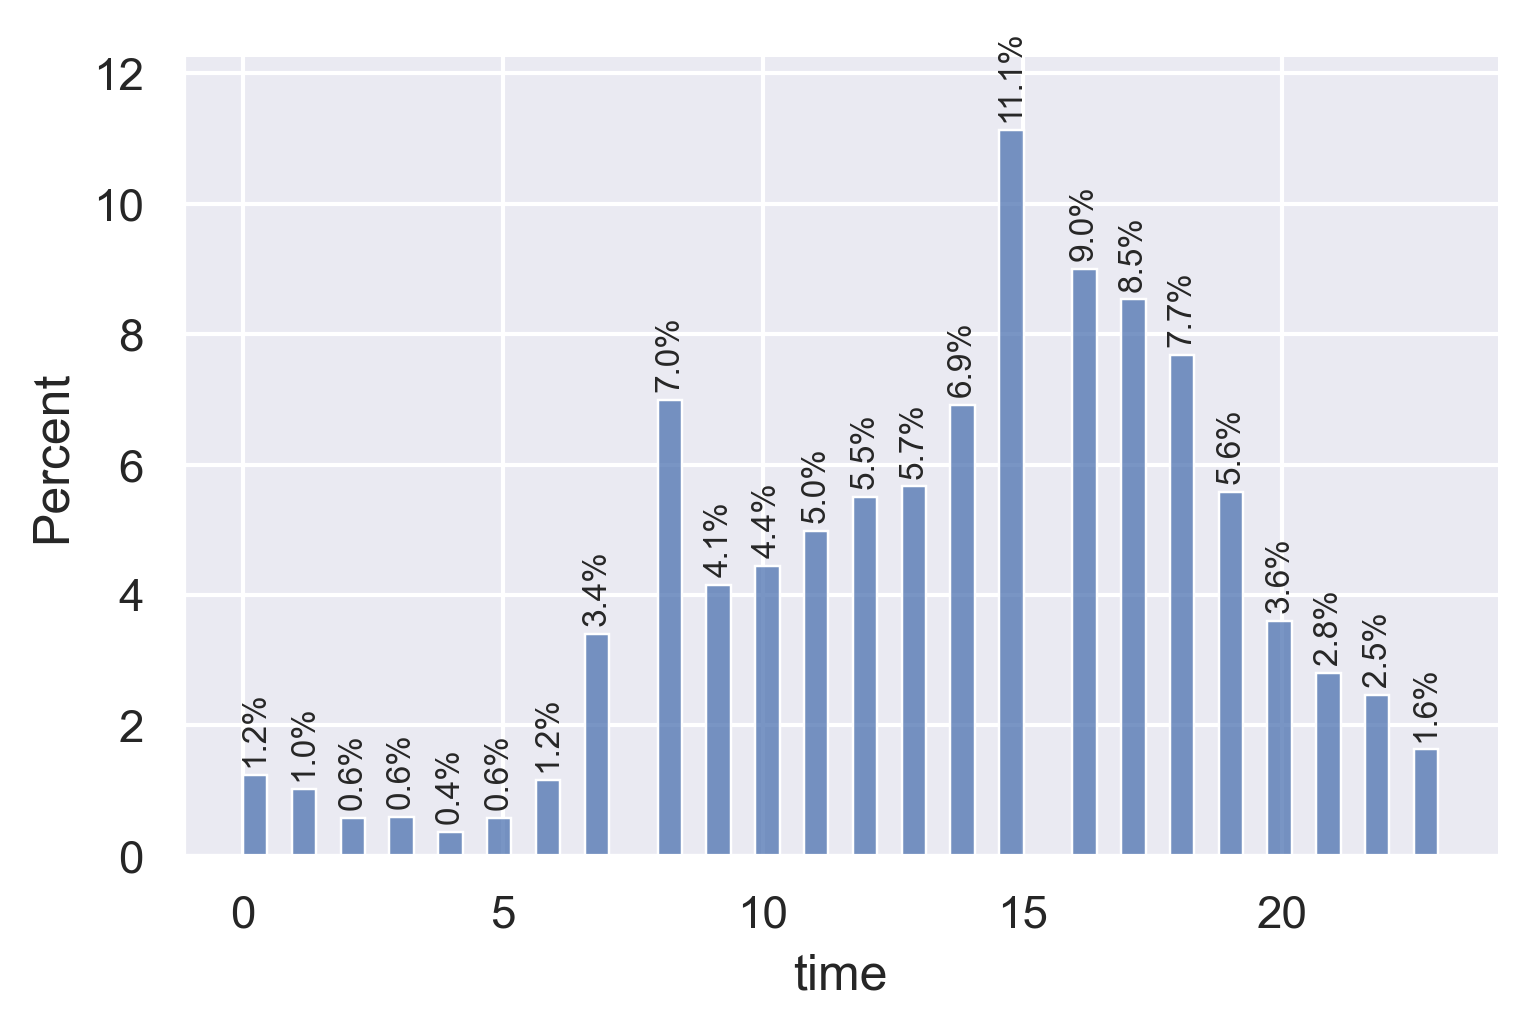

In [15]:
df_Ped = df[(df['casualty_class']=='Pedestrian')]

### Plot of Daily rate of pedestrian accidents

fg = sns.displot(data=df_Ped , x='time', stat='percent', height=3.5, aspect=1.5)
fg.fig.set_dpi(300)

for ax in fg.axes.ravel():
    
    # add annotations
    for c in ax.containers:

        # custom label calculates percent and add an empty string so 0 value bars don't have a number
        labels = [f'{w:0.1f}%' if (w := v.get_height()) > 0 else '' for v in c]

        ax.bar_label(c, labels=labels, label_type='edge', fontsize=8, rotation=90, padding=2)
    
    ax.margins(y=0.1)

plt.show()

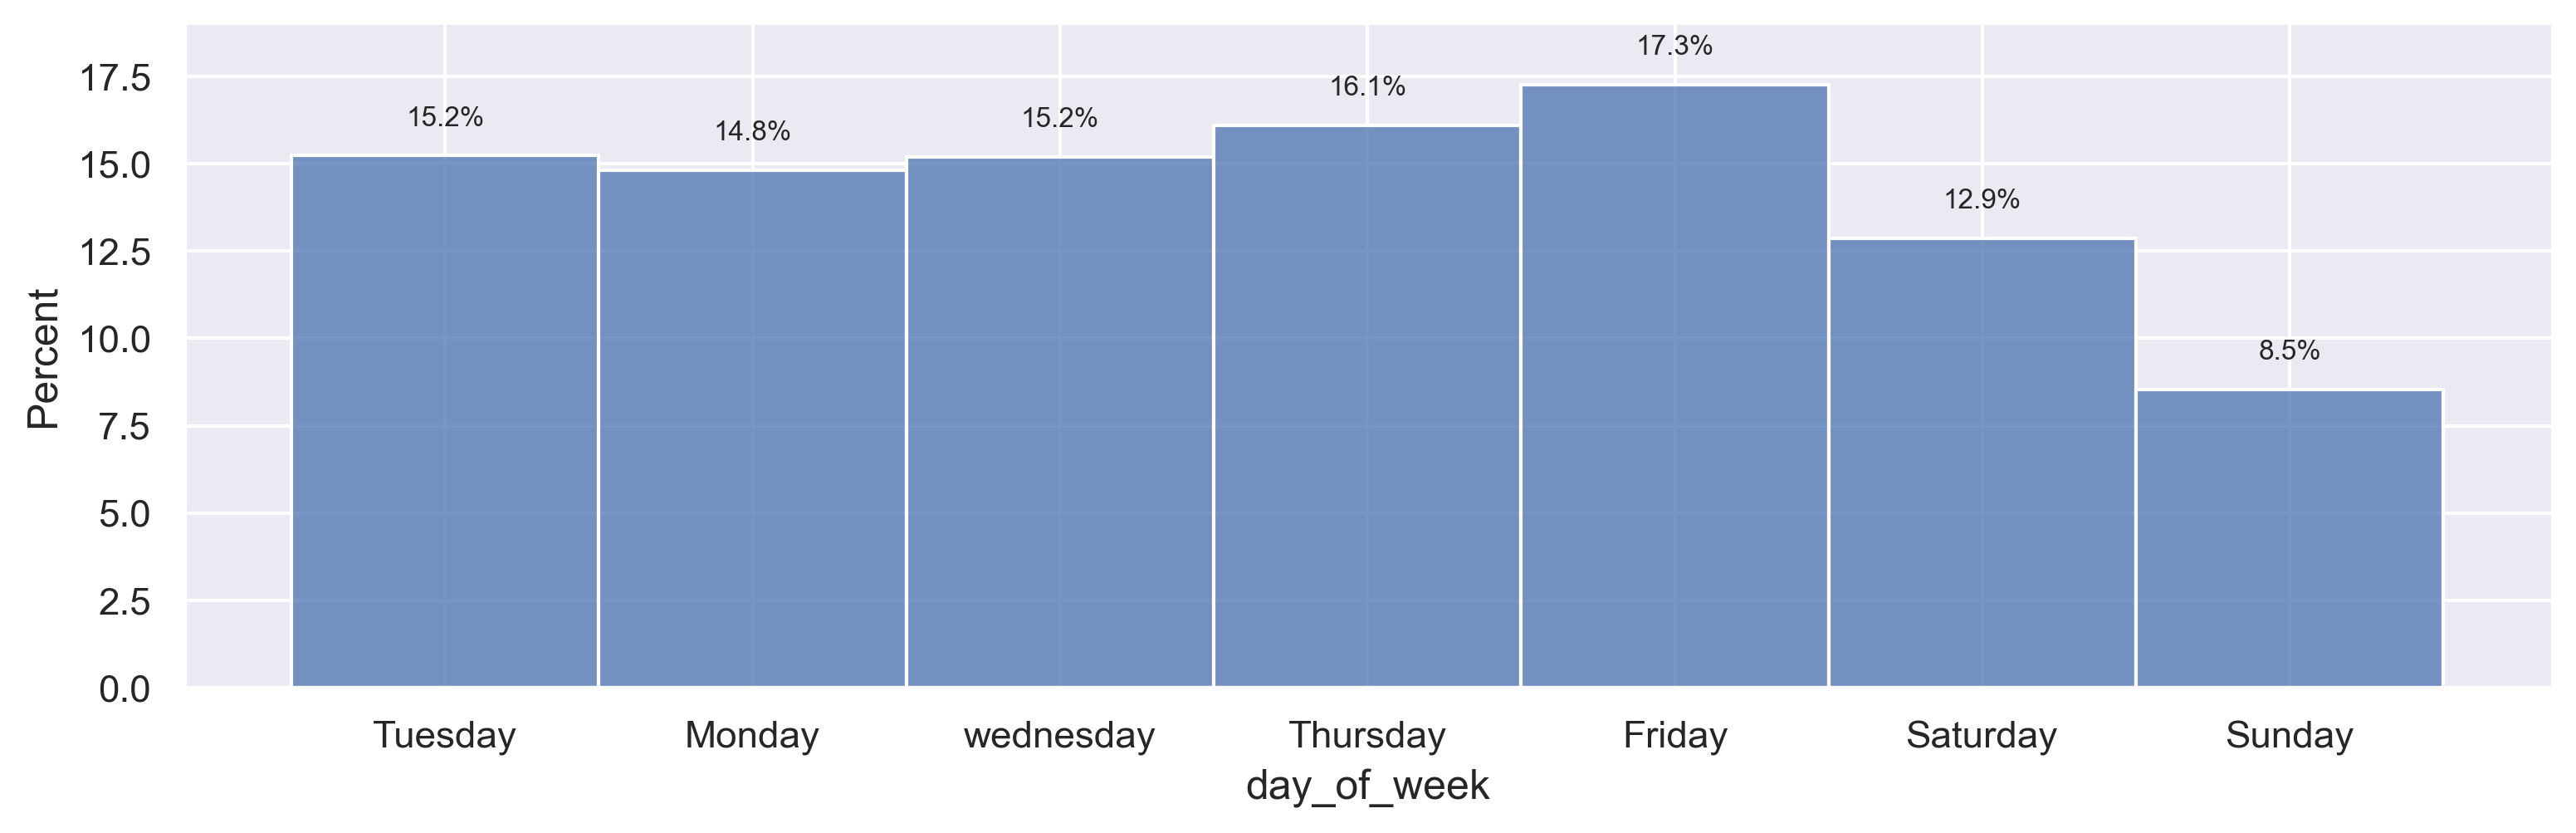

In [16]:
### Plot Daily rate of pedestrian accidents

fg = sns.displot(data=df_Ped , x='day_of_week', stat='percent', height=3.5, aspect=3)
fg.fig.set_dpi(300)

for ax in fg.axes.ravel():
    
    # add annotations
    for c in ax.containers:

        # custom label calculates percent and add an empty string so 0 value bars don't have a number
        labels = [f'{w:0.1f}%' if (w := v.get_height()) > 0 else '' for v in c]

        ax.bar_label(c, labels=labels, label_type='edge', fontsize=8, rotation=0, padding=7)
    
    ax.margins(y=0.1)

plt.show()

### 4.0 Using the apriori algorithm, explore the impact of selected variables on accident severity

In [17]:
##importing dependencies

from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules

In [18]:
### performing one-hot-encoding variables on the selected variables

a_severity = pd.get_dummies(df_acc.accident_severity, prefix = 'severity')
a_speed_limit = pd.get_dummies(df_acc.speed_limit, prefix = 'speed_limit')
a_weather_condition = pd.get_dummies(df_acc.weather_conditions, prefix = 'weather_conditions')
a_light_conditions = pd.get_dummies(df_acc.light_conditions, prefix = 'light_conditions')
a_road_surface_conditions = pd.get_dummies(df_acc.road_surface_conditions, prefix = 'road_surface_conditions')

In [149]:
df_acc_hot = pd.concat([a_severity.reset_index(drop=True),
                        a_speed_limit.reset_index(drop=True),
                        a_light_conditions.reset_index(drop=True),
                        a_weather_condition.reset_index(drop=True),
                        a_road_surface_conditions.reset_index(drop=True)
                       ], axis = 1)
df_acc_hot = df_acc_hot.rename(columns = {'severity_1':'Fatal','severity_2':'Serious','severity_3':'Slight'})

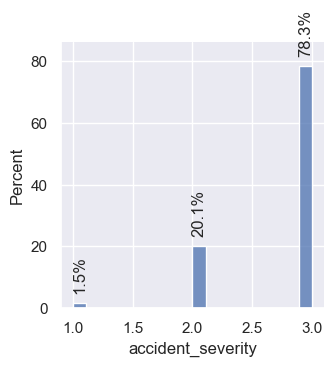

In [20]:
## determining the best minimum threshold

fg = sns.displot(data=df_acc, x='accident_severity', stat='percent', height=3.5, aspect=1)

for ax in fg.axes.ravel():
    
    # add annotations
    for c in ax.containers:

        # custom label calculates percent and add an empty string so 0 value bars don't have a number
        labels = [f'{w:0.1f}%' if (w := v.get_height()) > 0 else '' for v in c]

        ax.bar_label(c, labels=labels, label_type='edge', fontsize=12, rotation=90, padding=7)
    
    ax.margins(y=0.1)

plt.show() 

In [82]:
freq_itemsets = apriori(df_acc_hot, min_support=0.001, use_colnames=True)
freq_itemsets

C:\Users\hp\anaconda3\lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:110: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


,support,itemsets
0,0.015252,(Fatal)
1,0.201263,(Serious)
2,0.783484,(Slight)
3,0.122622,(speed_limit_20)
4,0.573033,(speed_limit_30)
...,...,...
1088,0.001272,"(light_conditions_4, speed_limit_70, weather_c..."
1089,0.001129,"(light_conditions_4, speed_limit_70, Slight, w..."
1090,0.002072,"(road_surface_conditions_1, speed_limit_70, we..."
1091,0.001272,"(speed_limit_70, weather_conditions_1, Slight,..."


In [83]:
rules =  association_rules(freq_itemsets , metric='lift', min_threshold=1.0)
rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,(Fatal),(speed_limit_40),0.015252,0.086262,0.001458,0.095615,1.108423,0.000143,1.010342,0.099332
1,(speed_limit_40),(Fatal),0.086262,0.015252,0.001458,0.016906,1.108423,0.000143,1.001682,0.107052
2,(Fatal),(speed_limit_50),0.015252,0.041470,0.001272,0.083393,2.010941,0.000639,1.045738,0.510507
3,(speed_limit_50),(Fatal),0.041470,0.015252,0.001272,0.030672,2.010941,0.000639,1.015907,0.524470
4,(Fatal),(speed_limit_60),0.015252,0.125089,0.005219,0.342200,2.735649,0.003311,1.330056,0.644283
...,...,...,...,...,...,...,...,...,...,...
6005,"(light_conditions_6, road_surface_conditions_2)","(weather_conditions_2, speed_limit_70, Slight)",0.028772,0.007193,0.001228,0.042683,5.933903,0.001021,1.037072,0.856109
6006,(weather_conditions_2),"(light_conditions_6, road_surface_conditions_2...",0.127008,0.003191,0.001228,0.009669,3.030359,0.000823,1.006542,0.767482
6007,(speed_limit_70),"(weather_conditions_2, road_surface_conditions...",0.051393,0.007083,0.001228,0.023896,3.373499,0.000864,1.017224,0.741690
6008,(light_conditions_6),"(weather_conditions_2, road_surface_conditions...",0.053016,0.006656,0.001228,0.023164,3.480350,0.000875,1.016900,0.752571


In [150]:
# showing every rule with class 'Fatal' in the consequents column
Fatal = rules[rules['consequents'].astype(str).str.contains('Fatal')].sort_values('lift', ascending = False)

# showing every rule with class 'Slight' in the consequent column
Serious = rules[rules['consequents'].astype(str).str.contains('Serious')].sort_values('support', ascending = False)

# showing every rule with class 'Slight' in the consequent column
Slight = rules[rules['consequents'].astype(str).str.contains('Slight')].sort_values('support', ascending = False)


In [104]:
## checking if all the classes of accident severity are represented in the association 

match = {'Slight'}
~rules['consequents'].apply(match.isdisjoint).unique()

array([False,  True])

### Filtering accident data on Kingston upon Hull, Humberside, and the East Riding of Yorkshire 

In [25]:
## Extracting the needed data from database by joining the accident table with the lsoa table
data = cur.execute('''SELECT accident.*, lsoa.lsoa01nm
                FROM accident JOIN vehicle ON accident.accident_index=vehicle.accident_index 
                JOIN casualty on accident.accident_index = casualty.accident_index 
                JOIN lsoa on accident.lsoa_of_accident_location=lsoa.lsoa01cd 
                WHERE accident.police_force ==16''').fetchall()
columns= acc_col_names + ['lsoa01nm']

# converting result to dataframe
df_region = pd.DataFrame(data, columns = columns)

### stripping the last four elements in 'lsoa01nm' column of the df_region table
df_region['lsoa01nm']= df_region['lsoa01nm'].str[:-4]

### CLUSTERING

In [26]:
from sklearn.cluster import KMeans

In [139]:
df_coord = df_region[['latitude','longitude']]
df_coord.head()

,latitude,longitude
0,53.745044,-0.393435
1,53.745044,-0.393435
2,53.862796,-0.268489
3,53.862796,-0.268489
4,53.862796,-0.268489


Text(0.5, 1.0, 'accidents location coordinate')

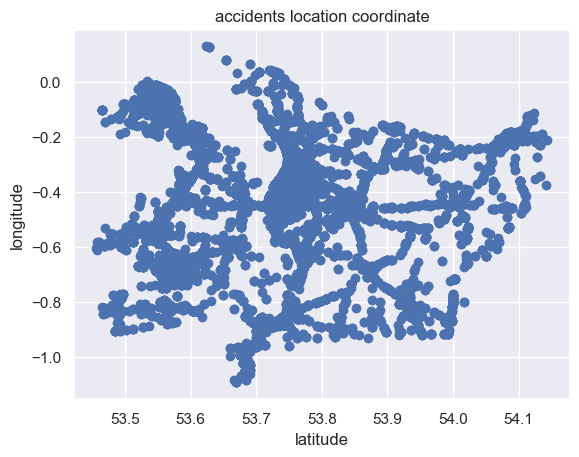

In [140]:
## plotting data points
 
plt.scatter(df_coord['latitude'], df_coord['longitude'])
plt.xlabel('latitude')
plt.ylabel('longitude')
plt.title('accidents location coordinate')

In [141]:
# plt.figure(figsize=(10,6))
# plt.scatter(df_region['weather_conditions'],df_region['accident_index'])
# plt.title('accidents in our humberside region')

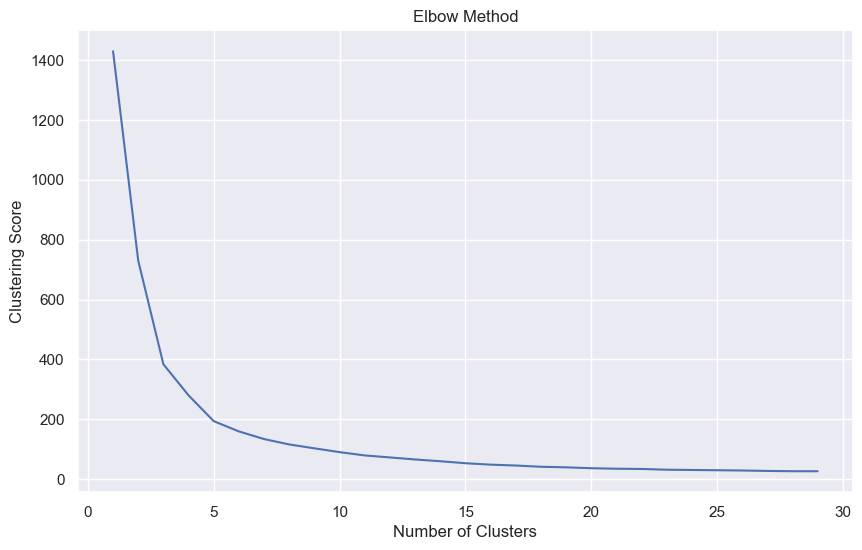

In [143]:
individual_clustering_score = []
for i in range(1,30):
    kmeans = KMeans(n_clusters = i, init = 'random', random_state = 42)
    kmeans.fit(df_coord)
    individual_clustering_score.append(kmeans.inertia_)
    
plt.figure(figsize=(10,6))
plt.plot(range(1,30), individual_clustering_score)
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('Clustering Score')
plt.show()

In [144]:
kmeans = KMeans(n_clusters = 5, random_state = 42)
kmeans.fit(df_coord)
labels = kmeans.predict(df_coord)
centroids = kmeans.cluster_centers_

In [145]:
labels

array([0, 0, 0, ..., 1, 0, 0])

In [146]:
df_coord['cluster'] = pd.DataFrame(labels, columns=['cluster'])

In [147]:
df_coord.head()

,latitude,longitude,cluster
0,53.745044,-0.393435,0
1,53.745044,-0.393435,0
2,53.862796,-0.268489,0
3,53.862796,-0.268489,0
4,53.862796,-0.268489,0


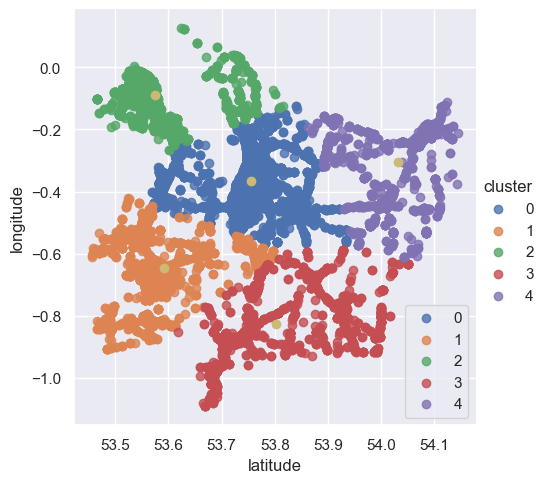

In [148]:
sns.lmplot(data=df_coord, x='latitude', y= 'longitude', fit_reg=False, hue='cluster', legend=True)
plt.legend(loc='lower right')
plt.scatter(centroids[:,0], centroids[:,1], color = 'y')
plt.show()

### Building a moodel that  predicts fatal injuries sustained in road traffic accidents

In [41]:
dfp = pd.concat([df_acc['accident_severity'].reset_index(drop=True),
                        a_speed_limit.reset_index(drop=True),
                        a_light_conditions.reset_index(drop=True),
                        a_weather_condition.reset_index(drop=True),
                        a_road_surface_conditions.reset_index(drop=True)
                       ], axis = 1)
dfp.head()

,accident_severity,speed_limit_10,speed_limit_20,speed_limit_30,speed_limit_40,speed_limit_50,speed_limit_60,speed_limit_70,light_conditions_1,light_conditions_4,light_conditions_5,light_conditions_6,light_conditions_7,weather_conditions_1,weather_conditions_2,weather_conditions_3,weather_conditions_4,weather_conditions_5,weather_conditions_6,weather_conditions_7,weather_conditions_8,weather_conditions_9,road_surface_conditions_1,road_surface_conditions_2,road_surface_conditions_3,road_surface_conditions_4,road_surface_conditions_5,road_surface_conditions_9
0,3,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1
1,3,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0
2,3,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3,2,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0
4,3,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0


In [42]:
# selecting the feature and taget variables

X = dfp.drop(['accident_severity'], axis=1)

y = dfp['accident_severity']

In [43]:
#### spliiting the data into 80% for training and 20% for testing

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)

In [44]:
##reshaping the target variable

y_train = y_train.values.reshape(-1,1)
y_test = y_test.values.reshape(-1,1)

In [45]:
# X_train_scaled = pd.DataFrame(X_train_scaled, columns = X_train.columns)
# X_test_scaled = pd.DataFrame(X_test_scaled, columns = X_test.columns)

In [46]:
print("X_train shape:",X_train.shape)
print("X_test shape:",X_test.shape)
print("y_train shape:",y_train.shape)
print("y_test shape:",y_test.shape)

X_train shape: (72959, 27)
X_test shape: (18240, 27)
y_train shape: (72959, 1)
y_test shape: (18240, 1)


In [47]:
#Standardizing the dataset

scale=StandardScaler()
scale.fit(X_train)
X_train = scale.transform(X_train)
X_test = scale.transform(X_test)

In [48]:
#To store results of models, we create two dictionaries
result_dict_train = {}
result_dict_test = {}

### logistic regression classifier

In [49]:
from sklearn.linear_model import LogisticRegression # importing the logistic regression library
from sklearn.model_selection import cross_val_score

reg = LogisticRegression(random_state = 42)
accuracies = cross_val_score(reg, X_train, y_train, cv=5)
reg.fit(X_train,y_train)
y_pred = reg.predict(X_test)

#Obtain accuracy
print("Train Score:",np.mean(accuracies))
print("Test Score:",reg.score(X_test,y_test))

#Store results in the dictionaries
result_dict_train["Logistic Train Score"] = np.mean(accuracies)
result_dict_test["Logistic Test Score"] = reg.score(X_test,y_test)

Train Score: 0.7834811334522482
Test Score: 0.7834978070175439


### KNeighbours classifier

In [ ]:
from sklearn.neighbors import KNeighborsClassifier #Importing the KNeighbours library

knn = KNeighborsClassifier()
accuracies = cross_val_score(knn, X_train, y_train, cv=5)
knn.fit(X_train,y_train)
y_pred = knn.predict(X_test)

#Obtain accuracy
print("Train Score:",np.mean(accuracies))
print("Test Score:",knn.score(X_test,y_test))

#Store results in the dictionaries
result_dict_train["Logistic Train Score"] = np.mean(accuracies)
result_dict_test["Logistic Test Score"] = reg.score(X_test,y_test)

### Decision tree classifier

In [68]:
from sklearn.tree import DecisionTreeClassifier

dtc = DecisionTreeClassifier(random_state = 42)
accuracies = cross_val_score(dtc, X_train, y_train, cv=5)
dtc.fit(X_train,y_train)
y_pred = dtc.predict(X_test)

#Obtain accuracy
print("Train Score:",np.mean(accuracies))
print("Test Score:",dtc.score(X_test,y_test))

#Store results in the dictionaries
result_dict_train["Decision Tree Train Score"] = np.mean(accuracies)
result_dict_test["Decision Tree Test Score"] = dtc.score(X_test,y_test)

Train Score: 0.7817541372234988
Test Score: 0.7821820175438596


### Random forest classifier

In [67]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(random_state = 42)
accuracies = cross_val_score(rfc, X_train, y_train, cv=5)
rfc.fit(X_train,y_train)
y_pred = rfc.predict(X_test)

#Obtain accuracy
print("Train Score:",np.mean(accuracies))
print("Test Score:",rfc.score(X_test,y_test))

#Store results in the dictionaries
result_dict_train["Random Forest Train Score"] = np.mean(accuracies)
result_dict_test["Random Forest Test Score"] = rfc.score(X_test,y_test)

Train Score: 0.7825353928596336
Test Score: 0.7823464912280702


### Naïve Bayes Classifier

In [ ]:
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()
accuracies = cross_val_score(gnb, X_train, y_train, cv=5)
gnb.fit(X_train,y_train)
y_pred = gnb.predict(X_test)

#Obtain accuracy
print("Train Score:",np.mean(accuracies))
print("Test Score:",gnb.score(X_test,y_test))

#Store results in the dictionaries
result_dict_train["Gaussian NB Train Score"] = np.mean(accuracies)
result_dict_test["Gaussian NB Test Score"] = gnb.score(X_test,y_test)

### ACCURACY COMPARISON

In [73]:
df_result_train = pd.DataFrame.from_dict(result_dict_train,orient = "index", columns=["Score"])
df_result_train

,Score
Logistic Train Score,0.710688
Gaussian NB Train Score,0.025480
Random Forest Train Score,0.782535
Decision Tree Train Score,0.781754


In [74]:
df_result_test = pd.DataFrame.from_dict(result_dict_test,orient = "index",columns=["Score"])
df_result_test


,Score
Logistic Test Score,0.783498
Gaussian NB Test Score,0.025658
Random Forest Test Score,0.782346
Decision Tree Test Score,0.782182


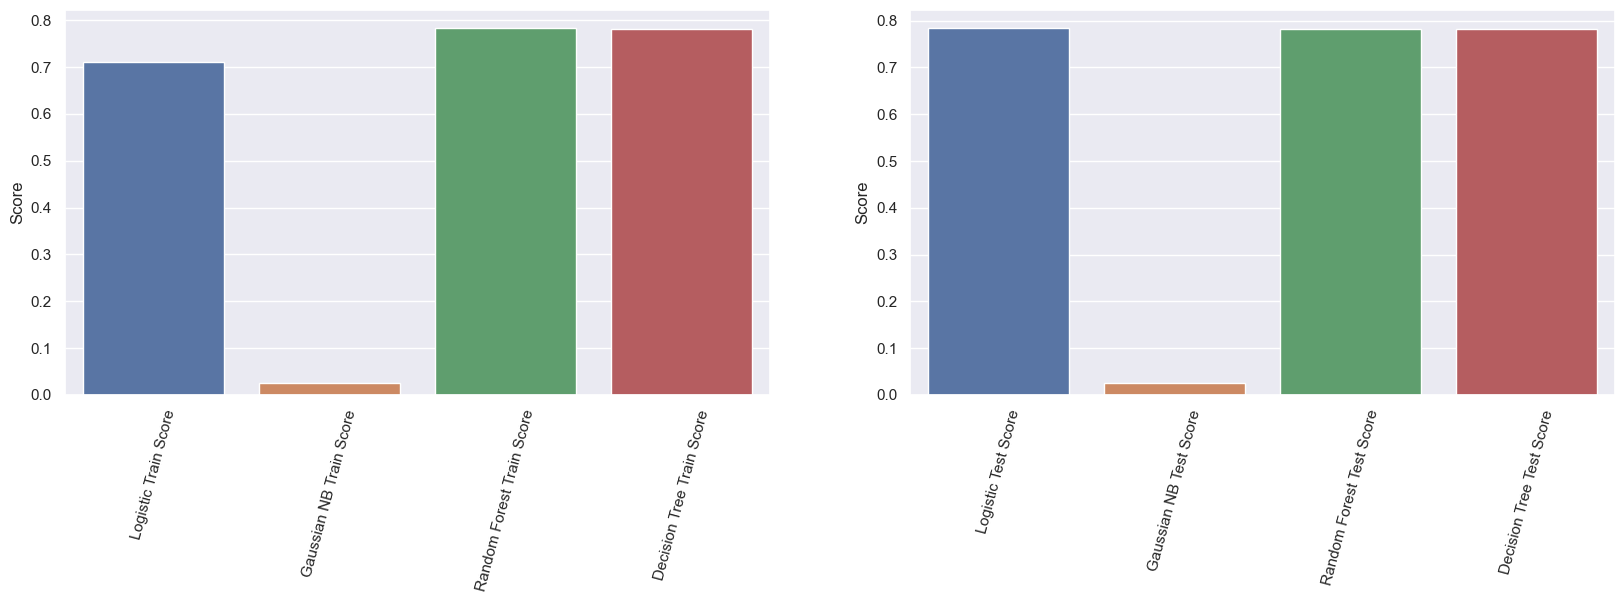

In [96]:
# showing the comparison between used clasffiers
import seaborn as sns

fig,ax = plt.subplots(1,2,figsize=(20,5))
sns.barplot(x = df_result_train.index,y = df_result_train.Score,ax = ax[0])
sns.barplot(x = df_result_test.index,y = df_result_test.Score,ax = ax[1])
ax[0].set_xticklabels(df_result_train.index,rotation = 75)
ax[1].set_xticklabels(df_result_test.index,rotation = 75)
plt.show()